# Directed KV Cache: Bug-Fix Rerun (Experiment 05)

## Objective

Rerun of experiment 04 (`directed_kvcache_corrected_routing`) with three critical
bug fixes in the library code. The experiment design and notebook code are identical
to 04; only the underlying `lib/kv_cache.py` has changed.

### Bug Fixes Applied

1. **RoPE correction used wrong dimension pairing (CRITICAL)**
   - The old code split keys into interleaved even/odd pairs (`keys[..., 0::2]`, `keys[..., 1::2]`)
   - Mistral's HuggingFace implementation uses **half-split** pairing via `rotate_half`:
     `x1 = x[..., :d/2]`, `x2 = x[..., d/2:]`
   - The inverse rotation was applied to the wrong dimension pairs, effectively
     scrambling keys instead of correcting positions
   - Fixed: now uses `_rotate_half` + full `(head_dim,)` cos/sin matching HF exactly
   - Validated: new tests apply HF's forward RoPE then our inverse, asserting identity

2. **Truncated cache was missing the BOS token**
   - `build_truncated_kv_cache_corrected` computed `doc_len` without BOS, so the
     truncated cache contained `[Document, :, \n, ...]` instead of `[<s>, Document, :, \n, ...]`
   - Baseline caches always started with BOS (`add_special_tokens=True`)
   - Fixed: new `extract_and_truncate_cache_with_bos` preserves BOS (position 0) +
     last N document tokens; `correct_rope_positions_with_bos` leaves BOS untouched

3. **Tokenizer boundary mismatch**
   - `doc_len` was computed by tokenizing the document text in isolation, but the
     actual tokens differ at the join boundary (e.g., `▁Document` vs `Document`)
   - Fixed: `doc_len` is now computed as `len(full_tokens) - len(prefix_tokens)`,
     both tokenized with `add_special_tokens=True`, avoiding boundary artifacts

### Expected Impact

With correct RoPE inversion, the truncated+corrected conditions should now properly
test whether surrogate-influenced KV entries improve downstream answer quality.
Previously these conditions were running with scrambled key vectors, making them
equivalent to a slightly-noisy baseline.

### Experimental Conditions (unchanged from 04, plus new routing-with-baseline)

| Condition | Description |
|-----------|-------------|
| **Baseline** | Document cached with framing (`"Document:\n{document}"`) |
| **Bare Document** | Document cached without framing (raw text only) |
| **Truncated + Corrected (5 gen + 5 static + perfect)** | Surrogate primed, truncated, RoPE corrected |
| **Full Context (routed gen + routed static + perfect)** | Surrogate kept visible during inference |
| **Full Context Random** | Random token prefix kept visible (positional control) |
| **Routed / Oracle** | Best surrogate selected by similarity / by NLL |
| **Routed-or-Baseline** | Router can pick the undirected baseline if no surrogate is a good match |

## Experimental Notes — Bug Fixes Motivating This Notebook

This notebook is a rerun of Experiment 04 after discovering **three critical bugs** in the library code:

**Bug 1 — Wrong RoPE dimension pairing (CRITICAL):** The old code in `correct_rope_positions()` split keys into interleaved even/odd pairs (`keys[..., 0::2]`, `keys[..., 1::2]`). But Mistral's HuggingFace implementation uses half-split pairing via `rotate_half`: `x1 = x[..., :d/2]`, `x2 = x[..., d/2:]`. The inverse rotation was applied to wrong dimension pairs, scrambling keys instead of correcting positions. Fixed in `lib/kv_cache.py`.

**Bug 2 — Truncated cache missing BOS token:** `build_truncated_kv_cache_corrected` computed `doc_len` without BOS, so the truncated cache was `[Document, :, \n, ...]` instead of `[<s>, Document, :, \n, ...]`. Baseline caches always started with BOS. Fixed with `extract_and_truncate_cache_with_bos`.

**Bug 3 — Tokenizer boundary mismatch:** `doc_len` was computed by tokenizing document text in isolation, but BPE tokens differ at join boundaries (e.g., `_Document` vs `Document`). Fixed by computing `doc_len = len(full_tokens) - len(prefix_tokens)`.

## Step 1: Setup

In [1]:
import sys
import os
import json
import time
import datetime
from typing import Dict, List, Any, Optional

import torch
import numpy as np
from tqdm.auto import tqdm
from scipy import stats
import matplotlib.pyplot as plt

# Ensure lib is importable
sys.path.insert(0, '.')

from lib import (
    ExperimentConfig,
    build_kv_cache,
    score_answer_with_cache,
    extract_and_truncate_cache,
    build_truncated_kv_cache,
    correct_rope_positions,
    build_truncated_kv_cache_corrected,
    generate_all_5_surrogates,
    compute_similarity,
    load_evaluation_samples,
    load_ms_marco,
    TOP_5_SURROGATE_TEMPLATES,
    STATIC_SURROGATE_QUERIES,
    analyze_experiment_results,
)

print(f"PyTorch: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

PyTorch: 2.10.0+cu128
CUDA available: True
GPU: NVIDIA L4
GPU Memory: 23.6 GB


In [2]:
# Configuration
config = ExperimentConfig(
    num_samples=100,
    min_passage_words=50,
    max_passage_words=300,
    surrogate_max_tokens=45,
    surrogate_temperature=0.3,
    seed=42,
)

print(f"Model: {config.model_name}")
print(f"Samples: {config.num_samples}")
print(f"Passage words: {config.min_passage_words}-{config.max_passage_words}")
print(f"Device: {config.device}")

Model: mistralai/Mistral-7B-Instruct-v0.2
Samples: 100
Passage words: 50-300
Device: cuda


## Step 2: Load Model, Tokenizer, and Embedding Model

In [3]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from sentence_transformers import SentenceTransformer

# Set seeds
torch.manual_seed(config.seed)
np.random.seed(config.seed)

# Load model (4-bit quantized)
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
)

print(f"Loading {config.model_name}...")
tokenizer = AutoTokenizer.from_pretrained(config.model_name)
model = AutoModelForCausalLM.from_pretrained(
    config.model_name,
    quantization_config=bnb_config,
    device_map="auto",
)
model.eval()
print(f"Model loaded on {config.device}")

# Load embedding model for routing
print(f"Loading embedding model: {config.embedding_model_name}")
embed_model = SentenceTransformer(config.embedding_model_name)
print("Embedding model loaded.")

Loading mistralai/Mistral-7B-Instruct-v0.2...


Loading weights:   0%|          | 0/291 [00:00<?, ?it/s]

Model loaded on cuda
Loading embedding model: all-MiniLM-L6-v2


Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Embedding model loaded.


## Step 3: Load Dataset

In [4]:
dataset = load_ms_marco(config)
samples = load_evaluation_samples(dataset, config, require_answer=True)
print(f"Loaded {len(samples)} evaluation samples")

# Quick sanity check
s = samples[0]
print(f"\nExample sample:")
print(f"  Query: {s['query'][:80]}...")
print(f"  Passage: {s['passage'][:80]}...")
print(f"  Answer: {s['answer'][:80]}")

`trust_remote_code` is not supported anymore.
Please check that the Hugging Face dataset 'microsoft/ms_marco' isn't based on a loading script and remove `trust_remote_code`.
If the dataset is based on a loading script, please ask the dataset author to remove it and convert it to a standard format like Parquet.


Loading microsoft/ms_marco dataset...
Dataset loaded: 10047 samples
Filtering samples...


Filtering:   0%|          | 0/10047 [00:00<?, ?it/s]

Selected 100 samples
Loaded 100 evaluation samples

Example sample:
  Query: tissue is formed from...
  Passage: Tissues are formed from cells. Cells group together in the body to form tissues....
  Answer: Tissues are formed from cells. Cells group together in the body to form tissues.


## Step 4: Surrogate Templates

We use 5 LLM-generated (document-specific) and 5 static (document-agnostic) surrogate queries.

In [5]:
print("=" * 80)
print("GENERATED SURROGATE TEMPLATES (document-specific, LLM-guided)")
print("=" * 80)
for key, tmpl in TOP_5_SURROGATE_TEMPLATES.items():
    print(f"  {key:30s} -> {tmpl['name']}")

print()
print("=" * 80)
print("STATIC SURROGATE QUERIES (same for all documents)")
print("=" * 80)
for key, info in STATIC_SURROGATE_QUERIES.items():
    print(f"  {key:30s} -> \"{info['query']}\"")

GENERATED SURROGATE TEMPLATES (document-specific, LLM-guided)
  target_question                -> Target Natural Language Question
  keyword_query                  -> Keyword-ese Query
  symptom_scenario               -> Symptom/Scenario Query
  misconception_negative         -> Misconception/Negative Query
  messy_realworld                -> Messy Real-World Query

STATIC SURROGATE QUERIES (same for all documents)
  static_definitional            -> "What is this and what does it mean?"
  static_procedural              -> "How do I do this step by step?"
  static_quantitative            -> "How much does this cost or how long does it take?"
  static_factual                 -> "What are the key facts I need to know?"
  static_problem                 -> "What problem does this solve?"


## Step 5: Test on One Sample

Verify the full pipeline works before running the main loop.

In [6]:
# Generate surrogates for the first sample
test_sample = samples[0]
print(f"Passage: {test_sample['passage'][:120]}...")
print(f"Query:   {test_sample['query']}")
print(f"Answer:  {test_sample['answer'][:80]}")
print()

test_surrogates = generate_all_5_surrogates(
    test_sample['passage'], model, tokenizer, config
)
print("Generated surrogates:")
for key, surr in test_surrogates.items():
    sim = compute_similarity(surr, test_sample['query'], embed_model)
    print(f"  {key:30s} -> \"{surr}\" (sim={sim:.3f})")

print()
print("Static surrogates:")
for key, info in STATIC_SURROGATE_QUERIES.items():
    sim = compute_similarity(info['query'], test_sample['query'], embed_model)
    print(f"  {key:30s} -> \"{info['query']}\" (sim={sim:.3f})")

# Test baseline cache
baseline_ctx = config.baseline_cache_template.format(document=test_sample['passage'])
bl_len, bl_cache = build_kv_cache(baseline_ctx, model, tokenizer, config)
query_prompt = config.query_template.format(query=test_sample['query'])
bl_nll = score_answer_with_cache(
    bl_cache, bl_len, query_prompt, test_sample['answer'],
    model, tokenizer, config
)
print(f"\nBaseline NLL: {bl_nll:.4f}")

# Test perfect surrogate (actual query)
pf_len, pf_cache = build_truncated_kv_cache_corrected(
    test_sample['query'], test_sample['passage'], model, tokenizer, config
)
pf_nll = score_answer_with_cache(
    pf_cache, pf_len, query_prompt, test_sample['answer'],
    model, tokenizer, config
)
print(f"Perfect surrogate NLL: {pf_nll:.4f}")
print(f"Delta (positive = better): {bl_nll - pf_nll:.4f}")

# Test one generated surrogate
first_key = list(test_surrogates.keys())[0]
first_surr = test_surrogates[first_key]
doc_len, corrected_cache = build_truncated_kv_cache_corrected(
    first_surr, test_sample['passage'], model, tokenizer, config
)
corrected_nll = score_answer_with_cache(
    corrected_cache, doc_len, query_prompt, test_sample['answer'],
    model, tokenizer, config
)
print(f"Generated surrogate NLL ({first_key}): {corrected_nll:.4f}")
print(f"Delta (positive = better): {bl_nll - corrected_nll:.4f}")

Passage: Tissues are formed from cells. Cells group together in the body to form tissues. Tissue is a group of cells that have si...
Query:   tissue is formed from
Answer:  Tissues are formed from cells. Cells group together in the body to form tissues.

Generated surrogates:
  target_question                -> "What is the definition and formation process of tissues in the body?" (sim=0.785)
  keyword_query                  -> "cells, tissue, structure, function, organs, group, origin." (sim=0.550)
  symptom_scenario               -> "Cells not forming proper tissue structures (e.g., tissues not grouping together)" (sim=0.570)
  misconception_negative         -> "Is it harmful to mix cells from different origins when forming tissue?" (or) "Mistakes to avoid when forming tissue from cells of different origins" (sim=0.519)
  messy_realworld                -> "Help me find info on how cells form tissues, asap! Plz include structure & function, cells from same origin, and organs." (sim=0.

## Step 6: Per-Sample Evaluation Function

In [7]:
def generate_random_prefix(passage, tokenizer, config, seed):
    """Generate a random token prefix roughly matching a typical surrogate length."""
    np.random.seed(seed)
    vocab_size = tokenizer.vocab_size
    # Generate ~20 random token IDs (typical surrogate prefix length)
    random_ids = np.random.randint(100, vocab_size, size=20)
    random_text = tokenizer.decode(random_ids, skip_special_tokens=True)
    return random_text


def evaluate_sample(
    sample: Dict,
    idx: int,
    model: AutoModelForCausalLM,
    tokenizer: AutoTokenizer,
    embed_model: SentenceTransformer,
    config: ExperimentConfig,
) -> Optional[Dict]:
    """
    Evaluate a single sample across all experimental conditions:

    A. Baselines:
       - baseline: "Document:\\n{document}"
       - bare_doc: "{document}" (no framing)

    B. Truncated + RoPE corrected:
       - 5 generated surrogates
       - 5 static surrogates
       - perfect surrogate (actual query)

    C. Full context (surrogate kept visible):
       - routed generated surrogate (best by similarity)
       - routed static surrogate (best by similarity)
       - perfect surrogate (actual query)
       - random prefix (positional control)

    D. Routed-or-Baseline (truncated):
       - Like B routing, but the undirected baseline cache is included as a
         routing candidate. The baseline's similarity score is computed by
         embedding the passage itself. If no surrogate is more similar to the
         query than the passage is, the router falls back to the baseline cache.

    Returns None if the sample should be skipped.
    """
    passage = sample['passage']
    query = sample['query']
    answer = sample['answer']

    # --- Guard: answer must tokenize to >= 2 tokens for a meaningful NLL ---
    answer_ids = tokenizer(
        answer, return_tensors='pt', add_special_tokens=False
    )['input_ids']
    if answer_ids.shape[1] < 2:
        return None

    query_prompt = config.query_template.format(query=query)

    # ==================== A. BASELINES ====================

    # A1: Standard baseline with framing
    baseline_context = config.baseline_cache_template.format(document=passage)
    baseline_len, baseline_cache = build_kv_cache(
        baseline_context, model, tokenizer, config
    )
    baseline_nll = score_answer_with_cache(
        baseline_cache, baseline_len, query_prompt, answer,
        model, tokenizer, config
    )

    # A2: Bare document (no "Document:\n" framing)
    bare_len, bare_cache = build_kv_cache(passage, model, tokenizer, config)
    bare_nll = score_answer_with_cache(
        bare_cache, bare_len, query_prompt, answer,
        model, tokenizer, config
    )

    # ==================== B. TRUNCATED + CORRECTED ====================

    # B1: Perfect surrogate (actual query), truncated + corrected
    perfect_doc_len, perfect_cache = build_truncated_kv_cache_corrected(
        query, passage, model, tokenizer, config
    )
    perfect_trunc_nll = score_answer_with_cache(
        perfect_cache, perfect_doc_len, query_prompt, answer,
        model, tokenizer, config
    )

    # B2: Generated surrogates, truncated + corrected
    generated_surrogates = generate_all_5_surrogates(passage, model, tokenizer, config)

    generated_similarities = {
        key: compute_similarity(surr, query, embed_model)
        for key, surr in generated_surrogates.items()
    }

    generated_nlls = {}
    for key, surrogate in generated_surrogates.items():
        doc_len, corrected_cache = build_truncated_kv_cache_corrected(
            surrogate, passage, model, tokenizer, config
        )
        nll = score_answer_with_cache(
            corrected_cache, doc_len, query_prompt, answer,
            model, tokenizer, config
        )
        generated_nlls[key] = nll

    # B3: Static surrogates, truncated + corrected
    static_surrogates = {key: info['query'] for key, info in STATIC_SURROGATE_QUERIES.items()}

    static_similarities = {
        key: compute_similarity(surr, query, embed_model)
        for key, surr in static_surrogates.items()
    }

    static_nlls = {}
    for key, surrogate in static_surrogates.items():
        doc_len, corrected_cache = build_truncated_kv_cache_corrected(
            surrogate, passage, model, tokenizer, config
        )
        nll = score_answer_with_cache(
            corrected_cache, doc_len, query_prompt, answer,
            model, tokenizer, config
        )
        static_nlls[key] = nll

    # ==================== ROUTING (truncated) ====================

    gen_routed_key = max(generated_similarities, key=generated_similarities.get)
    gen_routed_nll = generated_nlls[gen_routed_key]
    gen_routed_similarity = generated_similarities[gen_routed_key]

    gen_oracle_key = min(generated_nlls, key=generated_nlls.get)
    gen_oracle_nll = generated_nlls[gen_oracle_key]

    static_routed_key = max(static_similarities, key=static_similarities.get)
    static_routed_nll = static_nlls[static_routed_key]
    static_routed_similarity = static_similarities[static_routed_key]

    static_oracle_key = min(static_nlls, key=static_nlls.get)
    static_oracle_nll = static_nlls[static_oracle_key]

    # ==================== D. ROUTED-OR-BASELINE (truncated) ====================
    # Include the undirected baseline as a routing candidate.
    # The baseline's "surrogate" representation for similarity is the passage itself.
    baseline_similarity = compute_similarity(passage, query, embed_model)

    # Generated pool + baseline
    if baseline_similarity >= gen_routed_similarity:
        gen_routed_or_bl_nll = baseline_nll
        gen_routed_or_bl_chose_baseline = True
        gen_routed_or_bl_key = '__baseline__'
    else:
        gen_routed_or_bl_nll = gen_routed_nll
        gen_routed_or_bl_chose_baseline = False
        gen_routed_or_bl_key = gen_routed_key

    # Static pool + baseline
    if baseline_similarity >= static_routed_similarity:
        static_routed_or_bl_nll = baseline_nll
        static_routed_or_bl_chose_baseline = True
        static_routed_or_bl_key = '__baseline__'
    else:
        static_routed_or_bl_nll = static_routed_nll
        static_routed_or_bl_chose_baseline = False
        static_routed_or_bl_key = static_routed_key

    # Combined pool: all gen + all static + baseline
    all_similarities = {}
    all_similarities.update({f'gen_{k}': v for k, v in generated_similarities.items()})
    all_similarities.update({f'static_{k}': v for k, v in static_similarities.items()})
    all_similarities['__baseline__'] = baseline_similarity

    all_nlls = {}
    all_nlls.update({f'gen_{k}': v for k, v in generated_nlls.items()})
    all_nlls.update({f'static_{k}': v for k, v in static_nlls.items()})
    all_nlls['__baseline__'] = baseline_nll

    combined_routed_key = max(all_similarities, key=all_similarities.get)
    combined_routed_or_bl_nll = all_nlls[combined_routed_key]
    combined_routed_or_bl_chose_baseline = (combined_routed_key == '__baseline__')

    # ==================== C. FULL CONTEXT (surrogate kept visible) ====================

    # C1: Full-context routed generated surrogate
    gen_routed_surr = generated_surrogates[gen_routed_key]
    full_gen_context = config.surrogate_cache_template.format(
        surrogate=gen_routed_surr, document=passage
    )
    full_gen_len, full_gen_cache = build_kv_cache(
        full_gen_context, model, tokenizer, config
    )
    full_gen_nll = score_answer_with_cache(
        full_gen_cache, full_gen_len, query_prompt, answer,
        model, tokenizer, config
    )

    # C2: Full-context routed static surrogate
    static_routed_surr = static_surrogates[static_routed_key]
    full_static_context = config.surrogate_cache_template.format(
        surrogate=static_routed_surr, document=passage
    )
    full_static_len, full_static_cache = build_kv_cache(
        full_static_context, model, tokenizer, config
    )
    full_static_nll = score_answer_with_cache(
        full_static_cache, full_static_len, query_prompt, answer,
        model, tokenizer, config
    )

    # C3: Full-context perfect surrogate (actual query)
    full_perfect_context = config.surrogate_cache_template.format(
        surrogate=query, document=passage
    )
    full_perfect_len, full_perfect_cache = build_kv_cache(
        full_perfect_context, model, tokenizer, config
    )
    full_perfect_nll = score_answer_with_cache(
        full_perfect_cache, full_perfect_len, query_prompt, answer,
        model, tokenizer, config
    )

    # C4: Full-context random prefix (positional control)
    random_prefix = generate_random_prefix(passage, tokenizer, config, seed=config.seed + idx)
    full_random_context = config.surrogate_cache_template.format(
        surrogate=random_prefix, document=passage
    )
    full_random_len, full_random_cache = build_kv_cache(
        full_random_context, model, tokenizer, config
    )
    full_random_nll = score_answer_with_cache(
        full_random_cache, full_random_len, query_prompt, answer,
        model, tokenizer, config
    )

    return {
        'query': query,
        'answer_preview': answer[:50] + '...' if len(answer) > 50 else answer,

        # A. Baselines
        'baseline_nll': baseline_nll,
        'bare_nll': bare_nll,

        # B. Truncated + corrected
        'perfect_nll': perfect_trunc_nll,
        'delta_perfect': baseline_nll - perfect_trunc_nll,

        'generated_surrogates': generated_surrogates,
        'generated_similarities': generated_similarities,
        'generated_nlls': generated_nlls,
        'gen_routed_key': gen_routed_key,
        'gen_routed_nll': gen_routed_nll,
        'gen_routed_similarity': gen_routed_similarity,
        'gen_oracle_key': gen_oracle_key,
        'gen_oracle_nll': gen_oracle_nll,

        'static_surrogates': static_surrogates,
        'static_similarities': static_similarities,
        'static_nlls': static_nlls,
        'static_routed_key': static_routed_key,
        'static_routed_nll': static_routed_nll,
        'static_routed_similarity': static_routed_similarity,
        'static_oracle_key': static_oracle_key,
        'static_oracle_nll': static_oracle_nll,

        # C. Full context
        'full_gen_nll': full_gen_nll,
        'full_static_nll': full_static_nll,
        'full_perfect_nll': full_perfect_nll,
        'full_random_nll': full_random_nll,

        # D. Routed-or-Baseline
        'baseline_similarity': baseline_similarity,
        'gen_routed_or_bl_nll': gen_routed_or_bl_nll,
        'gen_routed_or_bl_chose_baseline': gen_routed_or_bl_chose_baseline,
        'gen_routed_or_bl_key': gen_routed_or_bl_key,
        'static_routed_or_bl_nll': static_routed_or_bl_nll,
        'static_routed_or_bl_chose_baseline': static_routed_or_bl_chose_baseline,
        'static_routed_or_bl_key': static_routed_or_bl_key,
        'combined_routed_or_bl_nll': combined_routed_or_bl_nll,
        'combined_routed_or_bl_chose_baseline': combined_routed_or_bl_chose_baseline,
        'combined_routed_or_bl_key': combined_routed_key,

        # Deltas vs baseline (positive = better)
        'delta_gen_routed': baseline_nll - gen_routed_nll,
        'delta_gen_oracle': baseline_nll - gen_oracle_nll,
        'delta_static_routed': baseline_nll - static_routed_nll,
        'delta_static_oracle': baseline_nll - static_oracle_nll,
        'delta_bare': baseline_nll - bare_nll,
        'delta_full_gen': baseline_nll - full_gen_nll,
        'delta_full_static': baseline_nll - full_static_nll,
        'delta_full_perfect': baseline_nll - full_perfect_nll,
        'delta_full_random': baseline_nll - full_random_nll,
        'delta_gen_routed_or_bl': baseline_nll - gen_routed_or_bl_nll,
        'delta_static_routed_or_bl': baseline_nll - static_routed_or_bl_nll,
        'delta_combined_routed_or_bl': baseline_nll - combined_routed_or_bl_nll,
    }

## Step 7: Run the Experiment

In [8]:
results = []
skipped = 0
errors = 0
start_time = time.time()

print("=" * 80)
print("RUNNING COMPREHENSIVE SURROGATE ROUTING EXPERIMENT")
print(f"Samples: {len(samples)}")
print(f"Per sample: 5 gen + 5 static + 1 perfect (truncated+corrected)")
print(f"          + full-context gen/static/perfect/random + bare doc")
print("=" * 80)

for idx, sample in enumerate(tqdm(samples, desc="Evaluating")):
    try:
        result = evaluate_sample(sample, idx, model, tokenizer, embed_model, config)
        if result is None:
            skipped += 1
            continue
        results.append(result)
    except Exception as e:
        errors += 1
        if errors <= 3:
            print(f"\n  Error on sample {idx}: {type(e).__name__}: {e}")
        continue

    # Progress report every 50 samples
    if len(results) > 0 and len(results) % 50 == 0:
        elapsed = time.time() - start_time
        rate = elapsed / len(results)
        remaining = rate * (len(samples) - idx - 1)

        recent = results[-50:]
        bl = np.mean([r['baseline_nll'] for r in recent])
        br = np.mean([r['bare_nll'] for r in recent])
        fg = np.mean([r['full_gen_nll'] for r in recent])
        fr = np.mean([r['full_random_nll'] for r in recent])
        gr = np.mean([r['gen_routed_nll'] for r in recent])
        wr_fg = np.mean([r['delta_full_gen'] > 0 for r in recent]) * 100
        wr_fr = np.mean([r['delta_full_random'] > 0 for r in recent]) * 100
        wr_gt = np.mean([r['delta_gen_routed'] > 0 for r in recent]) * 100

        print(
            f"\n  [{len(results):>4d} done | {elapsed/60:.0f}m elapsed | ~{remaining/60:.0f}m left]\n"
            f"  Last 50: baseline={bl:.3f}  bare={br:.3f}\n"
            f"    Full-ctx: gen={fg:.3f} ({wr_fg:.0f}% win)  random={fr:.3f} ({wr_fr:.0f}% win)\n"
            f"    Trunc:    gen_routed={gr:.3f} ({wr_gt:.0f}% win)"
        )

elapsed_total = time.time() - start_time
print(f"\nDone. {len(results)} evaluated, {skipped} skipped (short answer), {errors} errors.")
print(f"Total time: {elapsed_total/60:.1f} minutes ({elapsed_total/len(results):.1f}s per sample)")

RUNNING COMPREHENSIVE SURROGATE ROUTING EXPERIMENT
Samples: 100
Per sample: 5 gen + 5 static + 1 perfect (truncated+corrected)
          + full-context gen/static/perfect/random + bare doc


Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]


  [  50 done | 22m elapsed | ~19m left]
  Last 50: baseline=1.398  bare=1.087
    Full-ctx: gen=1.183 (76% win)  random=1.171 (88% win)
    Trunc:    gen_routed=1.117 (84% win)

Done. 91 evaluated, 9 skipped (short answer), 0 errors.
Total time: 38.5 minutes (25.4s per sample)


## Step 8: Analysis

In [9]:
from lib.analysis import print_analysis_summary

analysis = analyze_experiment_results(results)
print_analysis_summary(analysis)

# Perfect surrogate analysis (not covered by analyze_experiment_results)
perfect_nlls = np.array([r['perfect_nll'] for r in results])
deltas_perfect = np.array([r['delta_perfect'] for r in results])
baseline_nlls_arr = np.array([r['baseline_nll'] for r in results])

t_perfect, p_perfect = stats.ttest_rel(baseline_nlls_arr, perfect_nlls)

from lib.analysis import cohens_d
d_perfect = cohens_d(deltas_perfect)

print()
print("=" * 80)
print("PERFECT SURROGATE (actual query as surrogate, truncated + RoPE corrected)")
print("=" * 80)
print(f"  Mean NLL:    {np.mean(perfect_nlls):.4f} ± {np.std(perfect_nlls):.4f}")
print(f"  Mean Delta:  {np.mean(deltas_perfect):.4f} (positive = better than baseline)")
print(f"  Win Rate:    {np.mean(deltas_perfect > 0)*100:.1f}%")
print(f"  t-stat:      {t_perfect:.3f}")
print(f"  p-value:     {p_perfect:.4f}")
print(f"  Cohen's d:   {d_perfect:.4f}")

EXPERIMENT RESULTS SUMMARY

Samples analyzed: 91

ANSWER NLL BY CONDITION (lower = better)
Condition                          Mean NLL        Std
-------------------------------------------------------
Baseline (doc only)                  1.5170     2.0853
-------------------------------------------------------
Generated Routed                     1.2191     1.8191
Generated Oracle                     1.0877     1.7279
-------------------------------------------------------
Static Routed                        1.3095     1.8738
Static Oracle                        1.2165     1.8186

WIN RATES vs BASELINE (positive delta = surrogate better)
Generated Routed vs Baseline: 83.5%
Generated Oracle vs Baseline: 92.3%
Static Routed vs Baseline:    79.1%
Static Oracle vs Baseline:    87.9%

STATISTICAL SIGNIFICANCE
Generated Routed: t=6.324, p=0.0000
Static Routed:    t=4.873, p=0.0000
Gen vs Static:    t=-2.752, p=0.0072

PERFECT SURROGATE (actual query as surrogate, truncated + RoPE corrected

In [10]:
# Per-template breakdown
print("=" * 80)
print("PER-TEMPLATE BREAKDOWN: GENERATED SURROGATES")
print("=" * 80)
print(f"{'Template':<30} {'Mean NLL':>10} {'Delta':>10} {'Win%':>8} {'Routed':>8} {'Oracle':>8}")
print("-" * 80)
for key, st in analysis['gen_template_stats'].items():
    print(
        f"{key:<30} {st['mean_nll']:>10.4f} {st['mean_delta']:>10.4f}"
        f" {st['win_rate']*100:>7.1f}% {st['times_routed']:>8d} {st['times_oracle']:>8d}"
    )

print()
print("=" * 80)
print("PER-TEMPLATE BREAKDOWN: STATIC SURROGATES")
print("=" * 80)
print(f"{'Template':<30} {'Mean NLL':>10} {'Delta':>10} {'Win%':>8} {'Routed':>8} {'Oracle':>8}")
print("-" * 80)
for key, st in analysis['static_template_stats'].items():
    print(
        f"{key:<30} {st['mean_nll']:>10.4f} {st['mean_delta']:>10.4f}"
        f" {st['win_rate']*100:>7.1f}% {st['times_routed']:>8d} {st['times_oracle']:>8d}"
    )

PER-TEMPLATE BREAKDOWN: GENERATED SURROGATES
Template                         Mean NLL      Delta     Win%   Routed   Oracle
--------------------------------------------------------------------------------
target_question                    1.2126     0.3044    84.6%       56       21
keyword_query                      1.2404     0.2765    80.2%       13       15
symptom_scenario                   1.2116     0.3054    83.5%       13       10
misconception_negative             1.2017     0.3152    84.6%        5       23
messy_realworld                    1.1976     0.3194    80.2%        4       22

PER-TEMPLATE BREAKDOWN: STATIC SURROGATES
Template                         Mean NLL      Delta     Win%   Routed   Oracle
--------------------------------------------------------------------------------
static_definitional                1.3587     0.1582    75.8%       29        7
static_procedural                  1.2917     0.2252    79.1%        7       17
static_quantitative           

In [11]:
# Effect sizes and significance
print("=" * 80)
print("EFFECT SIZES")
print("=" * 80)
print(f"Cohen's d (gen routed vs baseline):    {analysis['cohens_d_gen_routed']:.4f}")
print(f"Cohen's d (static routed vs baseline): {analysis['cohens_d_static_routed']:.4f}")
print()
print(f"Generated beats static rate: {analysis['gen_beats_static_rate']*100:.1f}%")
print(f"Gen vs Static p-value:       {analysis['p_value_gen_vs_static']:.4f}")

# Routing efficiency: how close does routing get to oracle?
if analysis['mean_delta_gen_oracle'] != 0:
    gen_efficiency = analysis['mean_delta_gen_routed'] / analysis['mean_delta_gen_oracle'] * 100
    print(f"\nGenerated routing efficiency: {gen_efficiency:.1f}% of oracle")
if analysis['mean_delta_static_oracle'] != 0:
    static_efficiency = analysis['mean_delta_static_routed'] / analysis['mean_delta_static_oracle'] * 100
    print(f"Static routing efficiency:    {static_efficiency:.1f}% of oracle")

EFFECT SIZES
Cohen's d (gen routed vs baseline):    0.6630
Cohen's d (static routed vs baseline): 0.5108

Generated beats static rate: 63.7%
Gen vs Static p-value:       0.0072

Generated routing efficiency: 69.4% of oracle
Static routing efficiency:    69.0% of oracle


## Step 8b: Full-Context and Controls Analysis

These conditions test whether the benefit of a surrogate prefix is **semantic** (content
matters) or **positional** (any prefix helps). The `directed_kvcache_experiment` found
that random prefixes helped as much as meaningful surrogates when kept in full context.

In [12]:
# Full-context and control conditions analysis
baseline_arr = np.array([r['baseline_nll'] for r in results])
bare_arr = np.array([r['bare_nll'] for r in results])
full_gen_arr = np.array([r['full_gen_nll'] for r in results])
full_static_arr = np.array([r['full_static_nll'] for r in results])
full_perfect_arr = np.array([r['full_perfect_nll'] for r in results])
full_random_arr = np.array([r['full_random_nll'] for r in results])

conditions_extra = {
    'Bare Doc (no framing)':    ('bare_nll',         'delta_bare'),
    'Full-Ctx Gen (routed)':    ('full_gen_nll',     'delta_full_gen'),
    'Full-Ctx Static (routed)': ('full_static_nll',  'delta_full_static'),
    'Full-Ctx Perfect (query)': ('full_perfect_nll', 'delta_full_perfect'),
    'Full-Ctx Random Prefix':   ('full_random_nll',  'delta_full_random'),
    'Trunc+Corr Gen (routed)':  ('gen_routed_nll',   'delta_gen_routed'),
    'Trunc+Corr Perfect':       ('perfect_nll',      'delta_perfect'),
    'Trunc Gen+BL (routed)':    ('gen_routed_or_bl_nll',      'delta_gen_routed_or_bl'),
    'Trunc Static+BL (routed)': ('static_routed_or_bl_nll',   'delta_static_routed_or_bl'),
    'Trunc Combined+BL (rtd)':  ('combined_routed_or_bl_nll', 'delta_combined_routed_or_bl'),
}

cohens_d_label = "Cohen's d"

print('=' * 95)
print('ALL CONDITIONS vs BASELINE (sorted by Mean NLL)')
print('=' * 95)
print(f"{'Condition':<30} {'Mean NLL':>10} {'Std':>8} {'Delta':>10} {'Win%':>8} {'t-stat':>8} {'p-value':>10} {cohens_d_label:>10}")
print('-' * 95)
baseline_label = 'Baseline (Document:\\n{doc})'
print(f"{baseline_label:<30} {np.mean(baseline_arr):>10.4f} {np.std(baseline_arr):>8.4f} {'--':>10} {'--':>8} {'--':>8} {'--':>10} {'--':>10}")
print('-' * 95)

rows = []
for label, (nll_key, delta_key) in conditions_extra.items():
    nlls = np.array([r[nll_key] for r in results])
    deltas = np.array([r[delta_key] for r in results])
    t, p = stats.ttest_rel(baseline_arr, nlls)
    d = cohens_d(deltas)
    wr = np.mean(deltas > 0) * 100
    rows.append((np.mean(nlls), label, np.std(nlls), np.mean(deltas), wr, t, p, d))

rows.sort(key=lambda x: x[0])
for mean_nll, label, std, delta, wr, t, p, d in rows:
    sig = '*' if p < 0.05 else ' '
    print(f'{label:<30} {mean_nll:>10.4f} {std:>8.4f} {delta:>+10.4f} {wr:>7.1f}% {t:>8.2f} {p:>10.4f}{sig} {d:>10.4f}')

print()
print('KEY COMPARISON: Is the full-context benefit semantic or positional?')
print('-' * 80)
fg_mean = np.mean(full_gen_arr)
fr_mean = np.mean(full_random_arr)
t_sem, p_sem = stats.ttest_rel(full_gen_arr, full_random_arr)
print(f'  Full-ctx generated (routed) NLL: {fg_mean:.4f}')
print(f'  Full-ctx random prefix NLL:      {fr_mean:.4f}')
print(f'  Paired t-test (gen vs random):   t={t_sem:.3f}, p={p_sem:.4f}')
if p_sem < 0.05:
    if fg_mean < fr_mean:
        print('  -> Generated surrogate is SIGNIFICANTLY better than random prefix.')
        print('     The benefit has a semantic component beyond just positional effects.')
    else:
        print('  -> Random prefix is SIGNIFICANTLY better than generated surrogate.')
        print('     The benefit is purely positional; surrogate content may actually hurt.')
else:
    print('  -> No significant difference. The benefit is likely positional, not semantic.')

# --- Routed-or-Baseline analysis ---
print()
print('=' * 80)
print('ROUTED-OR-BASELINE: Can the router benefit from a baseline fallback?')
print('=' * 80)

gen_bl_rate = np.mean([r['gen_routed_or_bl_chose_baseline'] for r in results]) * 100
static_bl_rate = np.mean([r['static_routed_or_bl_chose_baseline'] for r in results]) * 100
combined_bl_rate = np.mean([r['combined_routed_or_bl_chose_baseline'] for r in results]) * 100

print(f'  Gen pool:      baseline chosen {gen_bl_rate:.1f}% of the time')
print(f'  Static pool:   baseline chosen {static_bl_rate:.1f}% of the time')
print(f'  Combined pool: baseline chosen {combined_bl_rate:.1f}% of the time')

# Compare routed-or-baseline vs plain routed
for label, rob_key, plain_key in [
    ('Gen',      'gen_routed_or_bl_nll',      'gen_routed_nll'),
    ('Static',   'static_routed_or_bl_nll',   'static_routed_nll'),
]:
    rob_arr = np.array([r[rob_key] for r in results])
    plain_arr = np.array([r[plain_key] for r in results])
    t, p = stats.ttest_rel(plain_arr, rob_arr)
    rob_wins = np.mean(rob_arr < plain_arr) * 100
    print(f'\n  {label}: routed-or-BL vs plain routed:')
    print(f'    Mean NLL: {np.mean(rob_arr):.4f} vs {np.mean(plain_arr):.4f}')
    print(f'    routed-or-BL wins {rob_wins:.1f}% (paired t={t:.3f}, p={p:.4f})')

# Combined pool vs best individual pool
combined_arr = np.array([r['combined_routed_or_bl_nll'] for r in results])
gen_rob_arr = np.array([r['gen_routed_or_bl_nll'] for r in results])
t_comb, p_comb = stats.ttest_rel(gen_rob_arr, combined_arr)
print(f'\n  Combined+BL vs Gen+BL:')
print(f'    Mean NLL: {np.mean(combined_arr):.4f} vs {np.mean(gen_rob_arr):.4f}')
print(f'    Combined wins {np.mean(combined_arr < gen_rob_arr)*100:.1f}% (p={p_comb:.4f})')

ALL CONDITIONS vs BASELINE (sorted by Mean NLL)
Condition                        Mean NLL      Std      Delta     Win%   t-stat    p-value  Cohen's d
-----------------------------------------------------------------------------------------------
Baseline (Document:\n{doc})        1.5170   2.0853         --       --       --         --         --
-----------------------------------------------------------------------------------------------
Bare Doc (no framing)              1.1944   1.6718    +0.3225    69.2%     5.00     0.0000*     0.5240
Trunc+Corr Gen (routed)            1.2191   1.8191    +0.2979    83.5%     6.32     0.0000*     0.6630
Trunc+Corr Perfect                 1.3010   1.8739    +0.2160    78.0%     5.07     0.0000*     0.5312
Full-Ctx Random Prefix             1.3073   1.9523    +0.2097    80.2%     6.56     0.0000*     0.6874
Full-Ctx Gen (routed)              1.3266   1.9384    +0.1903    74.7%     5.14     0.0000*     0.5384
Trunc Gen+BL (routed)              1.3272

## Step 9: Stratified Analysis by Baseline Difficulty

In [13]:
# Earlier experiments showed surrogates help most when baseline NLL is high.
# Does the RoPE correction change this pattern?

baseline_nlls = np.array([r['baseline_nll'] for r in results])
quartiles = np.percentile(baseline_nlls, [25, 50, 75])

bins = [
    ('Q1 (easiest)', lambda x: x <= quartiles[0]),
    ('Q2', lambda x: quartiles[0] < x <= quartiles[1]),
    ('Q3', lambda x: quartiles[1] < x <= quartiles[2]),
    ('Q4 (hardest)', lambda x: x > quartiles[2]),
]

print("=" * 100)
print("WIN RATE BY BASELINE DIFFICULTY QUARTILE")
print("=" * 100)
print(f"{'Quartile':<20} {'N':>5} {'BL NLL':>8} {'Perfect':>10} {'Prf Win%':>10} {'Gen Rtd':>10} {'Gen Win%':>10} {'Stc Rtd':>10} {'Stc Win%':>10}")
print("-" * 100)

for label, cond in bins:
    subset = [r for r in results if cond(r['baseline_nll'])]
    if not subset:
        continue
    bl = np.mean([r['baseline_nll'] for r in subset])
    pf = np.mean([r['perfect_nll'] for r in subset])
    gr = np.mean([r['gen_routed_nll'] for r in subset])
    sr = np.mean([r['static_routed_nll'] for r in subset])
    pw = np.mean([r['delta_perfect'] > 0 for r in subset]) * 100
    gw = np.mean([r['delta_gen_routed'] > 0 for r in subset]) * 100
    sw = np.mean([r['delta_static_routed'] > 0 for r in subset]) * 100
    print(f"{label:<20} {len(subset):>5} {bl:>8.3f} {pf:>10.3f} {pw:>9.1f}% {gr:>10.3f} {gw:>9.1f}% {sr:>10.3f} {sw:>9.1f}%")

WIN RATE BY BASELINE DIFFICULTY QUARTILE
Quartile                 N   BL NLL    Perfect   Prf Win%    Gen Rtd   Gen Win%    Stc Rtd   Stc Win%
----------------------------------------------------------------------------------------------------
Q1 (easiest)            23    0.088      0.068      56.5%      0.060      65.2%      0.064      56.5%
Q2                      23    0.559      0.495      87.0%      0.470      78.3%      0.498      78.3%
Q3                      22    1.186      0.872      90.9%      0.822      95.5%      0.926      90.9%
Q4 (hardest)            23    4.220      3.751      78.3%      3.506      95.7%      3.734      91.3%


## Step 10: Similarity-Delta Correlation

In [14]:
# Does a higher-similarity surrogate predict a bigger improvement?
gen_sims = np.array([r['gen_routed_similarity'] for r in results])
gen_deltas = np.array([r['delta_gen_routed'] for r in results])
static_sims = np.array([r['static_routed_similarity'] for r in results])
static_deltas = np.array([r['delta_static_routed'] for r in results])

r_gen, p_gen = stats.pearsonr(gen_sims, gen_deltas)
r_static, p_static = stats.pearsonr(static_sims, static_deltas)

print("=" * 80)
print("CORRELATION: SURROGATE-QUERY SIMILARITY vs NLL IMPROVEMENT")
print("=" * 80)
print(f"Generated routed: r={r_gen:.3f}, p={p_gen:.4f}")
print(f"Static routed:    r={r_static:.3f}, p={p_static:.4f}")

CORRELATION: SURROGATE-QUERY SIMILARITY vs NLL IMPROVEMENT
Generated routed: r=0.118, p=0.2649
Static routed:    r=-0.153, p=0.1485


## Step 11: Visualization

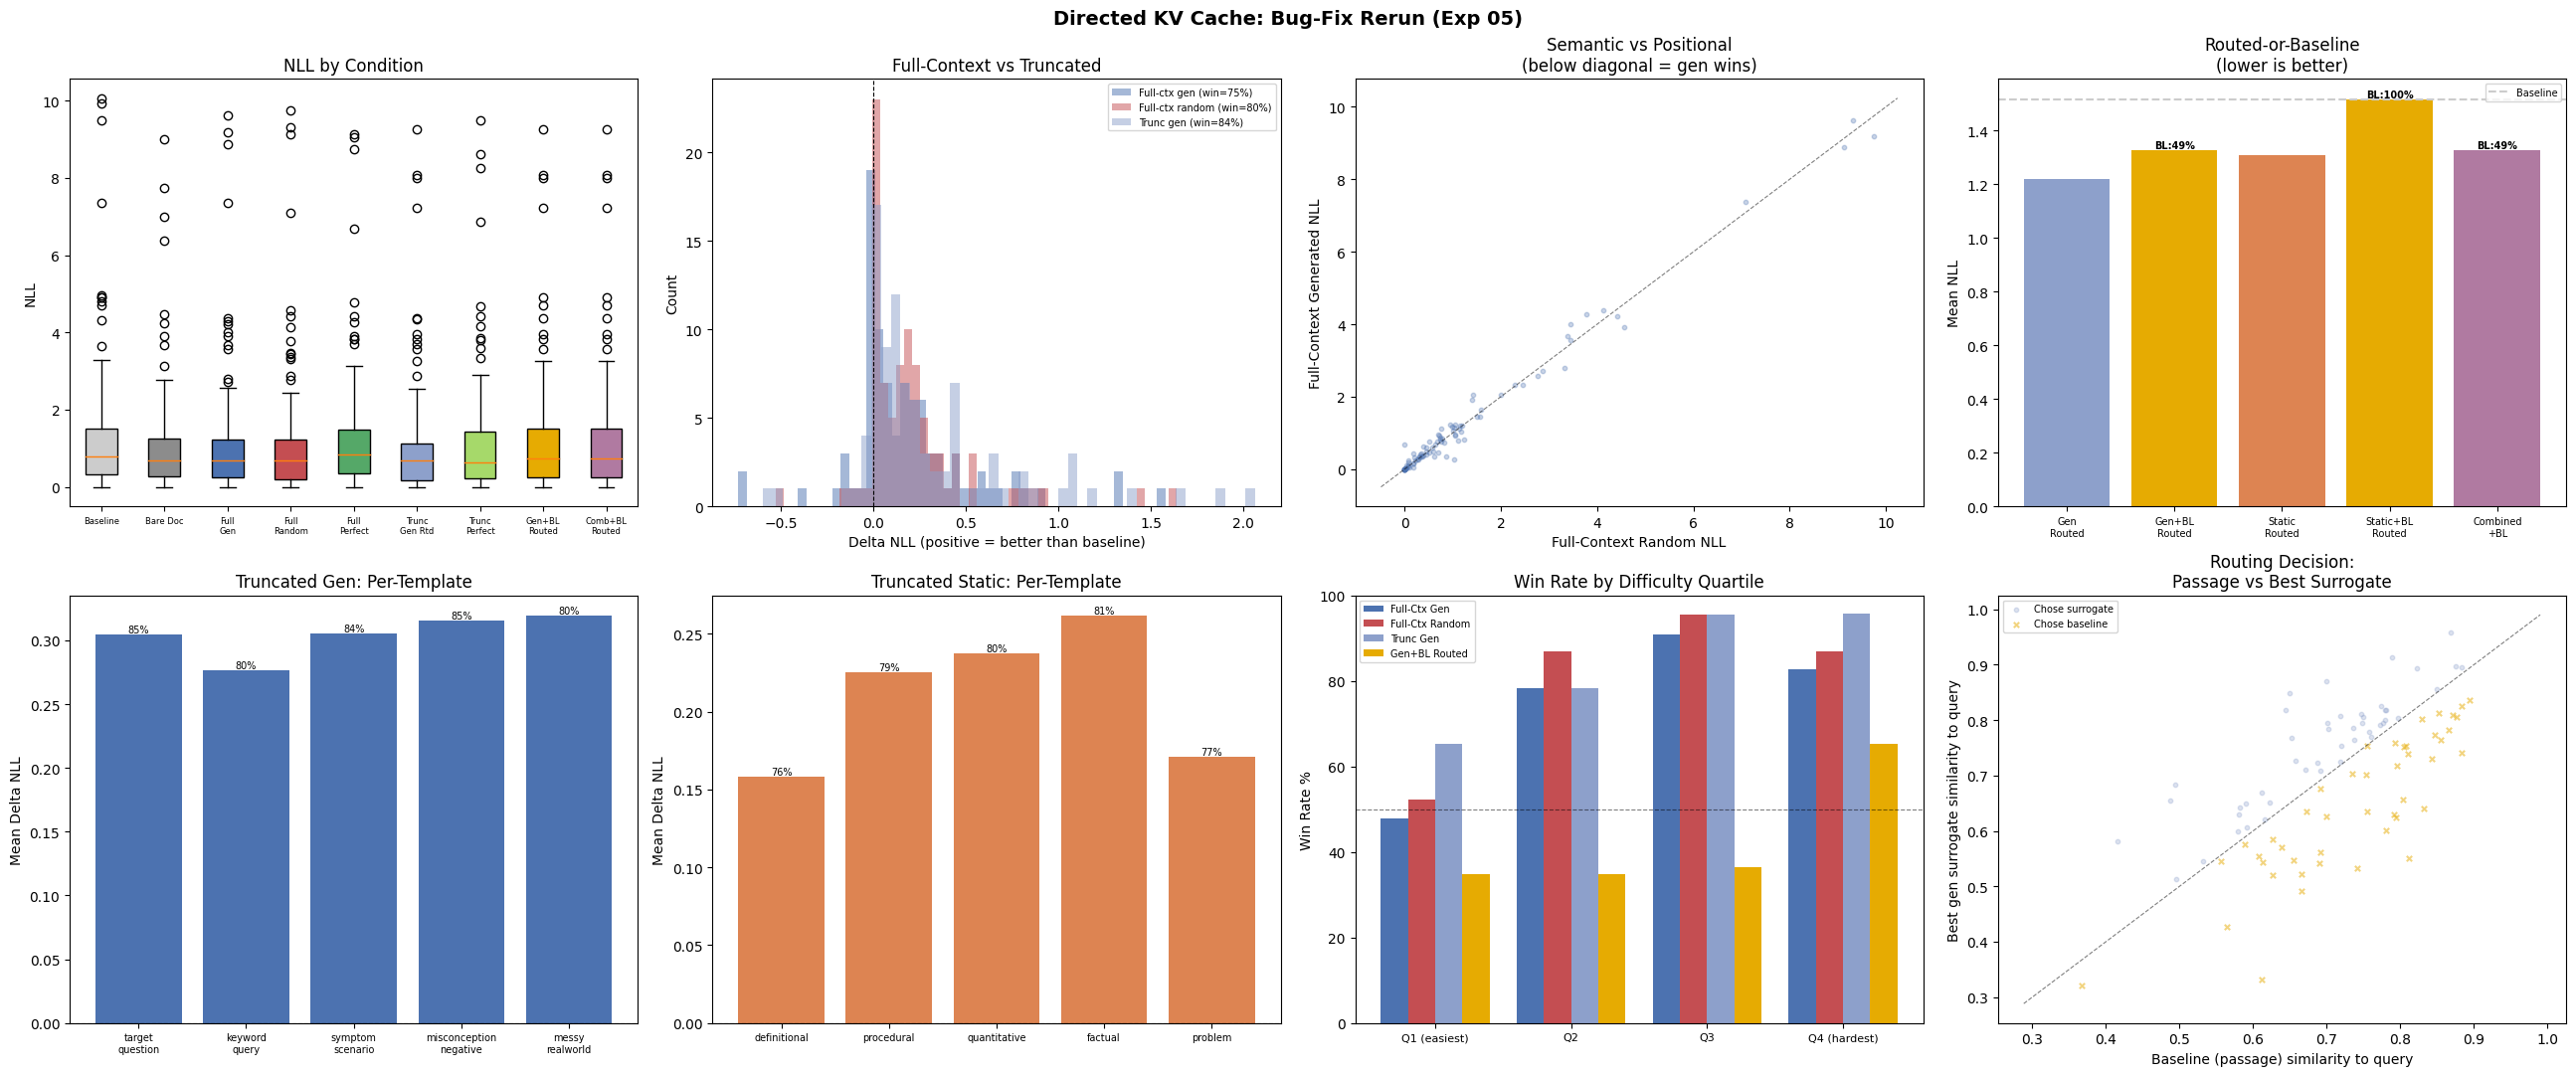

Saved: 05_bugfix_rerun_results.png


In [15]:
fig, axes = plt.subplots(2, 4, figsize=(26, 11))
fig.suptitle(
    'Directed KV Cache: Bug-Fix Rerun (Exp 05)',
    fontsize=14, fontweight='bold'
)

# --- Plot 1: All conditions NLL comparison ---
ax = axes[0, 0]
cond_labels = ['Baseline', 'Bare Doc', 'Full\nGen', 'Full\nRandom', 'Full\nPerfect',
               'Trunc\nGen Rtd', 'Trunc\nPerfect', 'Gen+BL\nRouted', 'Comb+BL\nRouted']
cond_data = [
    np.array([r['baseline_nll'] for r in results]),
    np.array([r['bare_nll'] for r in results]),
    np.array([r['full_gen_nll'] for r in results]),
    np.array([r['full_random_nll'] for r in results]),
    np.array([r['full_perfect_nll'] for r in results]),
    np.array([r['gen_routed_nll'] for r in results]),
    np.array([r['perfect_nll'] for r in results]),
    np.array([r['gen_routed_or_bl_nll'] for r in results]),
    np.array([r['combined_routed_or_bl_nll'] for r in results]),
]
cond_colors = ['#cccccc', '#8c8c8c', '#4c72b0', '#c44e52', '#55a868',
               '#8da0cb', '#a6d96a', '#e6ab02', '#b07aa1']
bp = ax.boxplot(cond_data, labels=cond_labels, patch_artist=True)
for patch, c in zip(bp['boxes'], cond_colors):
    patch.set_facecolor(c)
ax.set_ylabel('NLL')
ax.set_title('NLL by Condition')
ax.tick_params(axis='x', rotation=0, labelsize=6)

# --- Plot 2: Full-context vs Truncated delta distributions ---
ax = axes[0, 1]
delta_full_gen = np.array([r['delta_full_gen'] for r in results])
delta_full_random = np.array([r['delta_full_random'] for r in results])
delta_trunc_gen = np.array([r['delta_gen_routed'] for r in results])
ax.hist(delta_full_gen, bins=50, alpha=0.5,
        label=f'Full-ctx gen (win={np.mean(delta_full_gen>0)*100:.0f}%)', color='#4c72b0')
ax.hist(delta_full_random, bins=50, alpha=0.5,
        label=f'Full-ctx random (win={np.mean(delta_full_random>0)*100:.0f}%)', color='#c44e52')
ax.hist(delta_trunc_gen, bins=50, alpha=0.5,
        label=f'Trunc gen (win={np.mean(delta_trunc_gen>0)*100:.0f}%)', color='#8da0cb')
ax.axvline(0, color='black', linestyle='--', linewidth=0.8)
ax.set_xlabel('Delta NLL (positive = better than baseline)')
ax.set_ylabel('Count')
ax.set_title('Full-Context vs Truncated')
ax.legend(fontsize=7)

# --- Plot 3: Semantic vs Positional scatter ---
ax = axes[0, 2]
ax.scatter(
    [r['full_random_nll'] for r in results],
    [r['full_gen_nll'] for r in results],
    alpha=0.3, s=10, c='#4c72b0'
)
lims = [min(ax.get_xlim()[0], ax.get_ylim()[0]), max(ax.get_xlim()[1], ax.get_ylim()[1])]
ax.plot(lims, lims, 'k--', linewidth=0.8, alpha=0.5)
ax.set_xlabel('Full-Context Random NLL')
ax.set_ylabel('Full-Context Generated NLL')
ax.set_title('Semantic vs Positional\n(below diagonal = gen wins)')

# --- Plot 4: Routed-or-Baseline analysis ---
ax = axes[0, 3]
# Show how often baseline is chosen, and the NLL improvement
rob_labels = ['Gen\nRouted', 'Gen+BL\nRouted', 'Static\nRouted', 'Static+BL\nRouted', 'Combined\n+BL']
rob_means = [
    np.mean([r['gen_routed_nll'] for r in results]),
    np.mean([r['gen_routed_or_bl_nll'] for r in results]),
    np.mean([r['static_routed_nll'] for r in results]),
    np.mean([r['static_routed_or_bl_nll'] for r in results]),
    np.mean([r['combined_routed_or_bl_nll'] for r in results]),
]
rob_colors = ['#8da0cb', '#e6ab02', '#dd8452', '#e6ab02', '#b07aa1']
bl_mean = np.mean(baseline_arr)
bars = ax.bar(range(len(rob_labels)), rob_means, color=rob_colors)
ax.axhline(bl_mean, color='#cccccc', linestyle='--', linewidth=1.5, label='Baseline')
ax.set_xticks(range(len(rob_labels)))
ax.set_xticklabels(rob_labels, fontsize=7)
ax.set_ylabel('Mean NLL')
ax.set_title('Routed-or-Baseline\n(lower is better)')
ax.legend(fontsize=7)

# Annotate baseline-chosen rate on +BL bars
gen_bl_rate = np.mean([r['gen_routed_or_bl_chose_baseline'] for r in results]) * 100
static_bl_rate = np.mean([r['static_routed_or_bl_chose_baseline'] for r in results]) * 100
combined_bl_rate = np.mean([r['combined_routed_or_bl_chose_baseline'] for r in results]) * 100
for i, rate in [(1, gen_bl_rate), (3, static_bl_rate), (4, combined_bl_rate)]:
    ax.text(i, rob_means[i], f'BL:{rate:.0f}%', ha='center', va='bottom', fontsize=7, fontweight='bold')

# --- Plot 5: Per-template mean delta (generated, truncated) ---
ax = axes[1, 0]
gen_keys = list(analysis['gen_template_stats'].keys())
gen_means = [analysis['gen_template_stats'][k]['mean_delta'] for k in gen_keys]
gen_wins = [analysis['gen_template_stats'][k]['win_rate'] * 100 for k in gen_keys]
bar_colors = ['#4c72b0' if d > 0 else '#c44e52' for d in gen_means]
bars = ax.bar(range(len(gen_keys)), gen_means, color=bar_colors)
ax.set_xticks(range(len(gen_keys)))
ax.set_xticklabels([k.replace('_', '\n') for k in gen_keys], fontsize=7)
ax.axhline(0, color='black', linestyle='--', linewidth=0.8)
ax.set_ylabel('Mean Delta NLL')
ax.set_title('Truncated Gen: Per-Template')
for i, (bar, wr) in enumerate(zip(bars, gen_wins)):
    ax.text(i, bar.get_height(), f'{wr:.0f}%', ha='center', va='bottom', fontsize=7)

# --- Plot 6: Per-template mean delta (static, truncated) ---
ax = axes[1, 1]
static_keys = list(analysis['static_template_stats'].keys())
static_means = [analysis['static_template_stats'][k]['mean_delta'] for k in static_keys]
static_wins = [analysis['static_template_stats'][k]['win_rate'] * 100 for k in static_keys]
bar_colors_s = ['#dd8452' if d > 0 else '#c44e52' for d in static_means]
bars = ax.bar(range(len(static_keys)), static_means, color=bar_colors_s)
ax.set_xticks(range(len(static_keys)))
ax.set_xticklabels([k.replace('static_', '').replace('_', '\n') for k in static_keys], fontsize=7)
ax.axhline(0, color='black', linestyle='--', linewidth=0.8)
ax.set_ylabel('Mean Delta NLL')
ax.set_title('Truncated Static: Per-Template')
for i, (bar, wr) in enumerate(zip(bars, static_wins)):
    ax.text(i, bar.get_height(), f'{wr:.0f}%', ha='center', va='bottom', fontsize=7)

# --- Plot 7: Win rate by baseline quartile (full-ctx vs truncated) ---
ax = axes[1, 2]
q_labels = []
q_full_gen_wr = []
q_full_random_wr = []
q_trunc_gen_wr = []
q_gen_rob_wr = []
for label, cond in bins:
    subset = [r for r in results if cond(r['baseline_nll'])]
    if not subset:
        continue
    q_labels.append(label)
    q_full_gen_wr.append(np.mean([r['delta_full_gen'] > 0 for r in subset]) * 100)
    q_full_random_wr.append(np.mean([r['delta_full_random'] > 0 for r in subset]) * 100)
    q_trunc_gen_wr.append(np.mean([r['delta_gen_routed'] > 0 for r in subset]) * 100)
    q_gen_rob_wr.append(np.mean([r['delta_gen_routed_or_bl'] > 0 for r in subset]) * 100)

x_pos = np.arange(len(q_labels))
w = 0.2
ax.bar(x_pos - 1.5*w, q_full_gen_wr, w, label='Full-Ctx Gen', color='#4c72b0')
ax.bar(x_pos - 0.5*w, q_full_random_wr, w, label='Full-Ctx Random', color='#c44e52')
ax.bar(x_pos + 0.5*w, q_trunc_gen_wr, w, label='Trunc Gen', color='#8da0cb')
ax.bar(x_pos + 1.5*w, q_gen_rob_wr, w, label='Gen+BL Routed', color='#e6ab02')
ax.axhline(50, color='black', linestyle='--', linewidth=0.8, alpha=0.5)
ax.set_xticks(x_pos)
ax.set_xticklabels(q_labels, fontsize=8)
ax.set_ylabel('Win Rate %')
ax.set_title('Win Rate by Difficulty Quartile')
ax.legend(fontsize=7)
ax.set_ylim(0, 100)

# --- Plot 8: Baseline similarity distribution and routing decisions ---
ax = axes[1, 3]
bl_sims = np.array([r['baseline_similarity'] for r in results])
gen_best_sims = np.array([r['gen_routed_similarity'] for r in results])
chose_bl = np.array([r['gen_routed_or_bl_chose_baseline'] for r in results])

ax.scatter(bl_sims[~chose_bl], gen_best_sims[~chose_bl],
           alpha=0.3, s=10, c='#8da0cb', label='Chose surrogate')
ax.scatter(bl_sims[chose_bl], gen_best_sims[chose_bl],
           alpha=0.5, s=15, c='#e6ab02', label='Chose baseline', marker='x')
lims = [min(ax.get_xlim()[0], ax.get_ylim()[0]), max(ax.get_xlim()[1], ax.get_ylim()[1])]
ax.plot(lims, lims, 'k--', linewidth=0.8, alpha=0.5)
ax.set_xlabel('Baseline (passage) similarity to query')
ax.set_ylabel('Best gen surrogate similarity to query')
ax.set_title('Routing Decision:\nPassage vs Best Surrogate')
ax.legend(fontsize=7)

plt.tight_layout()
plt.savefig('results/exp05/05_bugfix_rerun_results.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: 05_bugfix_rerun_results.png')

## Step 12: Save Results

In [16]:
# Serialize results to JSON
output = {
    'metadata': {
        'experiment': '05_bugfix_rerun',
        'description': (
            'Rerun of experiment 04 with three bug fixes: '
            '(1) RoPE correction now uses half-split pairing matching HF rotate_half, '
            '(2) truncated cache preserves BOS token, '
            '(3) tokenizer boundary mismatch fixed. '
            '5 LLM-generated + 5 static surrogates per document, '
            'with similarity-based routing and oracle selection.'
        ),
        'timestamp': datetime.datetime.now().isoformat(),
        'model_name': config.model_name,
        'num_samples_requested': config.num_samples,
        'num_samples_evaluated': len(results),
        'num_skipped': skipped,
        'num_errors': errors,
        'elapsed_seconds': elapsed_total,
        'seed': config.seed,
        'min_passage_words': config.min_passage_words,
        'max_passage_words': config.max_passage_words,
        'surrogate_max_tokens': config.surrogate_max_tokens,
        'surrogate_temperature': config.surrogate_temperature,
    },
    'analysis': {
        k: (v if not isinstance(v, np.floating) else float(v))
        for k, v in analysis.items()
        if k not in ('gen_template_stats', 'static_template_stats')
    },
    'gen_template_stats': {
        k: {sk: float(sv) if isinstance(sv, np.floating) else sv for sk, sv in v.items()}
        for k, v in analysis['gen_template_stats'].items()
    },
    'static_template_stats': {
        k: {sk: float(sv) if isinstance(sv, np.floating) else sv for sk, sv in v.items()}
        for k, v in analysis['static_template_stats'].items()
    },
    'results': results,
}

output_path = 'results/exp05/05_bugfix_rerun_results.json'
with open(output_path, 'w') as f:
    json.dump(output, f, indent=2, default=str)
print(f"Results saved to {output_path}")
print(f"File size: {os.path.getsize(output_path) / 1e6:.1f} MB")

Results saved to 05_bugfix_rerun_results.json
File size: 0.4 MB


## Step 13: Conclusions

In [17]:
print('=' * 80)
print('CONCLUSIONS')
print('=' * 80)

print(f'\nSamples evaluated: {len(results)} (skipped {skipped}, errors {errors})')
print(f'\nBaseline (Document:\\n{{doc}}) mean NLL: {analysis["mean_baseline_nll"]:.4f}')

# Bare doc
bare_mean = np.mean([r['bare_nll'] for r in results])
bare_wr = np.mean([r['delta_bare'] > 0 for r in results]) * 100
t_bare, p_bare = stats.ttest_rel(baseline_arr, np.array([r['bare_nll'] for r in results]))
print(f'\n--- Bare Document (no framing) ---')
print(f'  Mean NLL: {bare_mean:.4f}  (win rate: {bare_wr:.1f}%, p={p_bare:.4f})')

# Full context conditions
for label, nll_key in [('Full-Ctx Gen (routed)', 'full_gen_nll'),
                        ('Full-Ctx Static (routed)', 'full_static_nll'),
                        ('Full-Ctx Perfect (query)', 'full_perfect_nll'),
                        ('Full-Ctx Random Prefix', 'full_random_nll')]:
    arr = np.array([r[nll_key] for r in results])
    delta = baseline_arr - arr
    t, p = stats.ttest_rel(baseline_arr, arr)
    wr = np.mean(delta > 0) * 100
    print(f'\n--- {label} ---')
    print(f'  Mean NLL: {np.mean(arr):.4f}  (win rate: {wr:.1f}%, p={p:.4f})')

# Truncated conditions
perfect_mean = np.mean([r['perfect_nll'] for r in results])
perfect_wr = np.mean([r['delta_perfect'] > 0 for r in results]) * 100
print(f'\n--- Trunc+Corr Perfect (actual query) ---')
print(f'  Mean NLL: {perfect_mean:.4f}  (win rate: {perfect_wr:.1f}%, p={p_perfect:.4f})')

print(f'\n--- Trunc+Corr Generated (routed) ---')
print(f'  Mean NLL: {analysis["mean_gen_routed_nll"]:.4f}  (win rate: {analysis["win_rate_gen_routed"]*100:.1f}%, p={analysis["p_value_gen_routed"]:.4f})')

print(f'\n--- Trunc+Corr Static (routed) ---')
print(f'  Mean NLL: {analysis["mean_static_routed_nll"]:.4f}  (win rate: {analysis["win_rate_static_routed"]*100:.1f}%, p={analysis["p_value_static_routed"]:.4f})')

# Routed-or-Baseline conditions
for label, nll_key, delta_key, bl_key in [
    ('Gen+BL (routed)',      'gen_routed_or_bl_nll',      'delta_gen_routed_or_bl',      'gen_routed_or_bl_chose_baseline'),
    ('Static+BL (routed)',   'static_routed_or_bl_nll',   'delta_static_routed_or_bl',   'static_routed_or_bl_chose_baseline'),
    ('Combined+BL (routed)', 'combined_routed_or_bl_nll', 'delta_combined_routed_or_bl', 'combined_routed_or_bl_chose_baseline'),
]:
    arr = np.array([r[nll_key] for r in results])
    deltas = np.array([r[delta_key] for r in results])
    t, p = stats.ttest_rel(baseline_arr, arr)
    wr = np.mean(deltas > 0) * 100
    bl_rate = np.mean([r[bl_key] for r in results]) * 100
    print(f'\n--- {label} ---')
    print(f'  Mean NLL: {np.mean(arr):.4f}  (win rate: {wr:.1f}%, p={p:.4f})')
    print(f'  Baseline chosen: {bl_rate:.1f}% of samples')

# Key interpretations
full_gen_mean = np.mean([r['full_gen_nll'] for r in results])
full_random_mean = np.mean([r['full_random_nll'] for r in results])
t_sem, p_sem = stats.ttest_rel(
    np.array([r['full_gen_nll'] for r in results]),
    np.array([r['full_random_nll'] for r in results])
)

print(f'\n{"=" * 80}')
print('KEY FINDINGS')
print('=' * 80)

trunc_gen_mean = analysis['mean_gen_routed_nll']
bl_mean = analysis['mean_baseline_nll']

print(f'\n1. TRUNCATED + CORRECTED vs BASELINE:')
if analysis['p_value_gen_routed'] < 0.05 and trunc_gen_mean < bl_mean:
    print('   Truncated+corrected caches significantly beat baseline.')
else:
    print('   Truncated+corrected caches do NOT significantly beat baseline.')
    print('   RoPE correction neutralizes truncation damage but preserves no semantic benefit.')

print(f'\n2. FULL-CONTEXT vs BASELINE:')
t_fc, p_fc = stats.ttest_rel(baseline_arr, np.array([r['full_gen_nll'] for r in results]))
if p_fc < 0.05 and full_gen_mean < bl_mean:
    print(f'   Full-context generated surrogates significantly improve over baseline (p={p_fc:.4f}).')
else:
    print(f'   Full-context generated surrogates do NOT significantly improve (p={p_fc:.4f}).')

print(f'\n3. SEMANTIC vs POSITIONAL (full-ctx gen vs full-ctx random):')
if p_sem < 0.05:
    if full_gen_mean < full_random_mean:
        print(f'   Generated > random (p={p_sem:.4f}): benefit has a SEMANTIC component.')
    else:
        print(f'   Random >= generated (p={p_sem:.4f}): benefit is POSITIONAL, not semantic.')
else:
    print(f'   No significant difference (p={p_sem:.4f}): benefit appears POSITIONAL.')

print(f'\n4. BARE DOCUMENT:')
if p_bare < 0.05 and bare_mean < bl_mean:
    print(f'   Bare doc (no framing) is significantly better than framed baseline (p={p_bare:.4f}).')
    print('   The "Document:\\n" framing text itself slightly hurts performance.')

print(f'\n5. ROUTED-OR-BASELINE (can the router benefit from a baseline fallback?):')
gen_rob_mean = np.mean([r['gen_routed_or_bl_nll'] for r in results])
gen_plain_mean = np.mean([r['gen_routed_nll'] for r in results])
t_rob, p_rob = stats.ttest_rel(
    np.array([r['gen_routed_nll'] for r in results]),
    np.array([r['gen_routed_or_bl_nll'] for r in results])
)
gen_bl_rate = np.mean([r['gen_routed_or_bl_chose_baseline'] for r in results]) * 100
if p_rob < 0.05 and gen_rob_mean < gen_plain_mean:
    print(f'   Adding baseline fallback SIGNIFICANTLY improves routing (p={p_rob:.4f}).')
    print(f'   Baseline chosen {gen_bl_rate:.1f}% of the time.')
    print('   The router correctly identifies when no surrogate is helpful.')
elif gen_bl_rate < 5:
    print(f'   Baseline rarely chosen ({gen_bl_rate:.1f}%). Surrogates almost always win similarity contest.')
else:
    print(f'   Baseline chosen {gen_bl_rate:.1f}% of the time, but no significant overall improvement (p={p_rob:.4f}).')

print('\n' + '=' * 80)

CONCLUSIONS

Samples evaluated: 91 (skipped 9, errors 0)

Baseline (Document:\n{doc}) mean NLL: 1.5170

--- Bare Document (no framing) ---
  Mean NLL: 1.1944  (win rate: 69.2%, p=0.0000)

--- Full-Ctx Gen (routed) ---
  Mean NLL: 1.3266  (win rate: 74.7%, p=0.0000)

--- Full-Ctx Static (routed) ---
  Mean NLL: 1.3491  (win rate: 69.2%, p=0.0000)

--- Full-Ctx Perfect (query) ---
  Mean NLL: 1.4183  (win rate: 65.9%, p=0.0064)

--- Full-Ctx Random Prefix ---
  Mean NLL: 1.3073  (win rate: 80.2%, p=0.0000)

--- Trunc+Corr Perfect (actual query) ---
  Mean NLL: 1.3010  (win rate: 78.0%, p=0.0000)

--- Trunc+Corr Generated (routed) ---
  Mean NLL: 1.2191  (win rate: 83.5%, p=0.0000)

--- Trunc+Corr Static (routed) ---
  Mean NLL: 1.3095  (win rate: 79.1%, p=0.0000)

--- Gen+BL (routed) ---
  Mean NLL: 1.3272  (win rate: 42.9%, p=0.0001)
  Baseline chosen: 49.5% of samples

--- Static+BL (routed) ---
  Mean NLL: 1.5170  (win rate: 0.0%, p=nan)
  Baseline chosen: 100.0% of samples

--- Combi